# Imports

Run both of these cells:

In [2]:
#@title All `dm_control` imports required for this tutorial
# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

env: MUJOCO_GL=egl


In [10]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

# Model definition, compilation and rendering



We begin by describing some basic concepts of the [MuJoCo](http://mujoco.org/) physics simulation library, but recommend the [official documentation](http://mujoco.org/book/) for details.

Let's define a simple model with two geoms and a light.

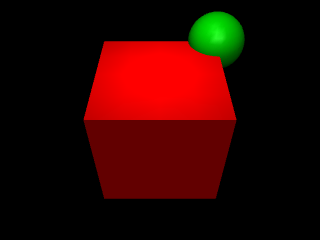

In [11]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

`static_model` is written in MuJoCo's XML-based [MJCF](http://www.mujoco.org/book/modeling.html) modeling language. The `from_xml_string()` method invokes the model compiler, which instantiates the library's internal data structures. These can be accessed via the `physics` object, see below.

## Adding DOFs and simulating, advanced rendering
This is a perfectly legitimate model, but if we simulate it, nothing will happen except for time advancing. This is because this model has no degrees of freedom (DOFs). We add DOFs by adding **joints** to bodies, specifying how they can move with respect to their parents. Let us add a hinge joint and re-render, visualizing the joint axis.

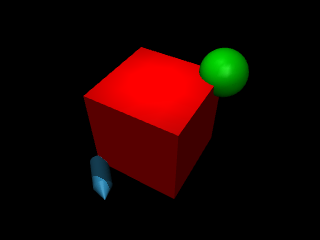

In [12]:
#@title A child body with a joint { vertical-output: true }

swinging_body = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">  
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(swinging_body)
# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

The things that move (and which have inertia) are called *bodies*. The body's child `joint` specifies how that body can move with respect to its parent, in this case `box_and_sphere` w.r.t the `worldbody`. 

Note that the body's frame is **rotated** with an `euler` directive, and its children, the geoms and the joint, rotate with it. This is to emphasize the local-to-parent-frame nature of position and orientation directives in MJCF.

Let's make a video, to get a sense of the dynamics and to see the body swinging under gravity.

In [13]:
#@title Making a video {vertical-output: true}

duration = 2    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)

Note how we collect the video frames. Because physics simulation timesteps are generally much smaller than framerates (the default timestep is 2ms), we don't render after each step.

## Rendering options

Like joint visualisation, additional rendering options are exposed as parameters to the `render` method.

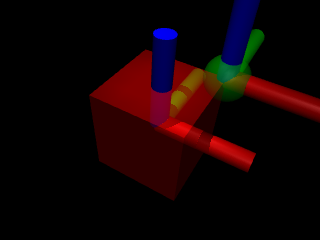

In [14]:
#@title Enable transparency and frame visualization {vertical-output: true}

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.frame = enums.mjtFrame.mjFRAME_GEOM
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

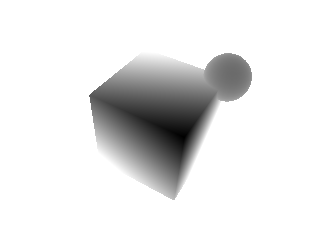

In [15]:
#@title Depth rendering {vertical-output: true}

# depth is a float array, in meters.
depth = physics.render(depth=True)
# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)
PIL.Image.fromarray(pixels.astype(np.uint8))

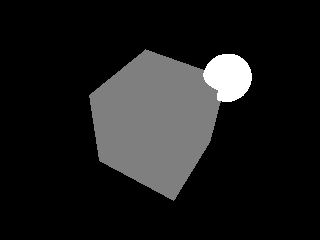

In [16]:
#@title Segmentation rendering {vertical-output: true}

seg = physics.render(segmentation=True)
# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255*geom_ids
PIL.Image.fromarray(pixels.astype(np.uint8))


/home/alex/miniconda3/envs/mujoco/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


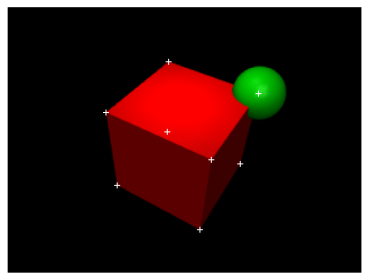

In [17]:
#@title Projecting from world to camera coordinates {vertical-output: true}

# Get the world coordinates of the box corners
box_pos = physics.named.data.geom_xpos['red_box']
box_mat = physics.named.data.geom_xmat['red_box'].reshape(3, 3)
box_size = physics.named.model.geom_size['red_box']
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(itertools.product(*offsets)).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
camera = mujoco.Camera(physics)
camera_matrix = camera.matrix

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = camera_matrix @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = camera.render()
fig, ax = plt.subplots(1, 1)
ax.imshow(pixels)
ax.plot(x, y, '+', c='w')
ax.set_axis_off()

# MuJoCo basics and named indexing

## `mjModel`
MuJoCo's `mjModel`, encapsulated in `physics.model`, contains the *model description*, including the default initial state and other fixed quantities which are not a function of the state, e.g. the positions of geoms in the frame of their parent body. The (x, y, z) offsets of the `box` and `sphere` geoms, relative their parent body `box_and_sphere` are given by `model.geom_pos`:

In [18]:
physics.model.geom_pos

array([[0. , 0. , 0. ],
       [0.2, 0.2, 0.2]])

The `model.opt` structure contains global quantities like

In [19]:
print('timestep', physics.model.opt.timestep)
print('gravity', physics.model.opt.gravity)

timestep 0.002
gravity [ 0.    0.   -9.81]


## `mjData`
`mjData`, encapsulated in `physics.data`, contains the *state* and quantities that depend on it. The state is made up of time, generalized positions and generalised velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. 

Let's print the state of the swinging body where we left it:

In [20]:
print(physics.data.time, physics.data.qpos, physics.data.qvel)

2.0000000000000013 [-0.05319467] [-1.36253678]


`physics.data` also contains functions of the state, for example the cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [ ]:
print(physics.data.geom_xpos)

## Named indexing

The semantics of the above arrays are made clearer using the `named` wrapper, which assigns names to rows and type names to columns.

In [ ]:
print(physics.named.data.geom_xpos)

Note how `model.geom_pos` and `data.geom_xpos` have similar semantics but very different meanings.

In [ ]:
print(physics.named.model.geom_pos)

Name strings can be used to index **into** the relevant quantities, making code much more readable and robust.

In [14]:
physics.named.data.geom_xpos['green_sphere', 'z']

0.16935693635325777

Joint names can be used to index into quantities in configuration space (beginning with the letter `q`):

In [13]:
physics.named.data.qpos['swing']

array([-0.05319467])

We can mix NumPy slicing operations with named indexing. As an example, we can set the color of the box using its name (`"red_box"`) as an index into the rows of the `geom_rgba` array. 

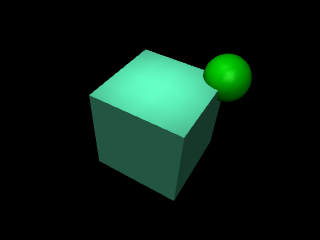

In [21]:
#@title Changing colors using named indexing{vertical-output: true}

random_rgb = np.random.rand(3)
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

Note that while `physics.model` quantities will not be changed by the engine, we can change them ourselves between steps. This however is generally not recommended, the preferred approach being to modify the model at the XML level using the PyMJCF library, see below.

## Setting the state with `reset_context()`

In order for `data` quantities that are functions of the state to be in sync with the state, MuJoCo's `mj_step1()` needs to be called. This is facilitated by the `reset_context()` context, please see in-depth discussion in Section 2.1 of the [tech report](https://arxiv.org/abs/2006.12983).

In [16]:
physics.named.data.qpos['swing'] = np.pi
print('Without reset_context, spatial positions are not updated:',
      physics.named.data.geom_xpos['green_sphere', ['z']])
with physics.reset_context():
  physics.named.data.qpos['swing'] = np.pi
print('After reset_context, positions are up-to-date:',
      physics.named.data.geom_xpos['green_sphere', ['z']])

Without reset_context, spatial positions are not updated: [0.16935694]
After reset_context, positions are up-to-date: [-0.6]


## Free bodies: the self-inverting "tippe-top"

A free body is a body with a `free` joint, with 6 movement DOFs: 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself on its head ([Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:

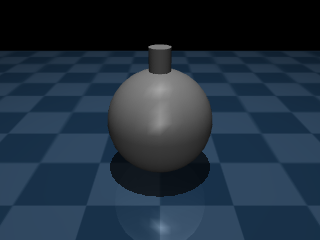

In [22]:
#@title The "tippe-top" model{vertical-output: true}

tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>
  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015" 
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(tippe_top)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

Note several new features of this model definition:
0. The free joint is added with the `<freejoint/>` clause, which is similar to `<joint type="free"/>`, but prohibits unphysical attributes like friction or stiffness.
1. We use the `<option/>` clause to set the integrator to the more accurate Runge Kutta 4th order.
2. We define the floor's grid material inside the `<asset/>` clause and reference it in the floor geom. 
3. We use an invisible and non-colliding box geom called `ballast` to move the top's center-of-mass lower. Having a low center of mass is  (counter-intuitively) required for the flipping behaviour to occur.
4. We save our initial spinning state as a keyframe. It has a high rotational velocity around the z-axis, but is not perfectly oriented with the world.
5. We define a `<camera>` in our model, and then render from it using the `camera_id` argument to `render()`.
Let us examine the state:

In [18]:
print('positions', physics.data.qpos)
print('velocities', physics.data.qvel)

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


The velocities are easy to interpret, 6 zeros, one for each DOF. What about the length-7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. These normalized four-vectors, which preserve the topology of the orientation group, are the reason that `data.qpos` can be bigger than `data.qvel`: 3D orientations are represented with **4** numbers while angular velocities are **3** numbers.

In [23]:
#@title Video of the tippe-top {vertical-output: true}

duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset(0)  # Reset to keyframe 0 (load a saved state).
while physics.data.time < duration:
  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render(camera_id='closeup')
    frames.append(pixels)

display_video(frames, framerate)

### Measuring values from `physics.data`
The `physics.data` structure contains all of the dynamic variables and intermediate results produced by the simulation. These are expected to change on each timestep. 

Below we simulate for 2000 timesteps and plot the state and height of the sphere as a function of time.

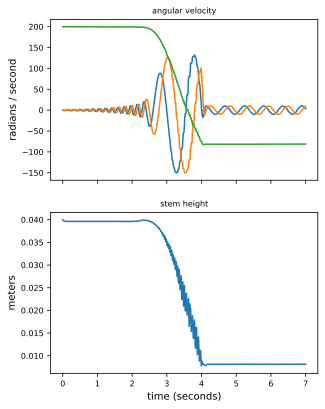

In [24]:
#@title Measuring values {vertical-output: true}

timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
physics.reset(0)
while physics.data.time < duration:
  physics.step()
  timevals.append(physics.data.time)
  angular_velocity.append(physics.data.qvel[3:6].copy())
  stem_height.append(physics.named.data.geom_xpos['stem', 'z'])

dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

# PyMJCF tutorial




This library provides a Python object model for MuJoCo's XML-based
[MJCF](http://www.mujoco.org/book/modeling.html) physics modeling language. The
goal of the library is to allow users to easily interact with and modify MJCF
models in Python, similarly to what the JavaScript DOM does for HTML.

A key feature of this library is the ability to easily compose multiple separate
MJCF models into a larger one. Disambiguation of duplicated names from different
models, or multiple instances of the same model, is handled automatically.

One typical use case is when we want robots with a variable number of joints. This is a fundamental change to the kinematics, requiring a new XML descriptor and new binary model to be compiled. 

The following snippets realise this scenario and provide a quick example of this library's use case.

In [25]:
class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 2
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba  # Continued below...

    # Thigh:
    self.thigh = self.model.worldbody.add('body')
    self.hip = self.thigh.add('joint', axis=[0, 0, 1])
    self.thigh.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/4])

    # Hip:
    self.shin = self.thigh.add('body', pos=[length, 0, 0])
    self.knee = self.shin.add('joint', axis=[0, 1, 0])
    self.shin.add('geom', fromto=[0, 0, 0, 0, 0, -length], size=[length/5])

    # Position actuators:
    self.model.actuator.add('position', joint=self.hip, kp=10)
    self.model.actuator.add('position', joint=self.knee, kp=10)

The `Leg` class describes an abstract articulated leg, with two joints and corresponding proportional-derivative actuators. 

Note that:

- MJCF attributes correspond directly to arguments of the `add()` method.
- When referencing elements, e.g when specifying the joint to which an actuator is attached, the MJCF element itself is used, rather than the name string.

In [26]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState(42)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  model = mjcf.RootElement()
  model.compiler.angle = 'radian'  # Use radians.

  # Make the torso geom.
  model.worldbody.add(
      'geom', name='torso', type='ellipsoid', size=BODY_SIZE, rgba=rgba)

  # Attach legs to equidistant sites on the circumference.
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0, 0, theta])
    leg = Leg(length=BODY_RADIUS, rgba=rgba)
    hip_site.attach(leg.model)

  return model

The `make_creature` function uses PyMJCF's `attach()` method to procedurally attach legs to the torso. Note that at this stage both the torso and hip attachment sites are children of the `worldbody`, since their parent body has yet to be instantiated. We'll now make an arena with a chequered floor and two lights, and place our creatures in a grid.

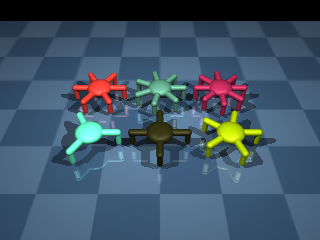

In [27]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

Multi-legged creatures, ready to roam! Let's inject some controls and watch them move. We'll generate a sinusoidal open-loop control signal of fixed frequency and random phase, recording both video frames and the horizontal positions of the torso geoms, in order to plot the movement trajectories.

In [28]:
#@title Video of the movement{vertical-output: true}
#@test {"timeout": 600}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
torsos = []  # List of torso geom elements.
actuators = []  # List of actuator elements.
for creature in creatures:
  torsos.append(creature.find('geom', 'torso'))
  actuators.extend(creature.find_all('actuator'))

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
physics.reset()
while physics.data.time < duration:
  # Inject controls and step the physics.
  physics.bind(actuators).ctrl = amp * np.sin(freq * physics.data.time + phase)
  physics.step()

  # Save torso horizontal positions using bind().
  pos_x.append(physics.bind(torsos).xpos[:, 0].copy())
  pos_y.append(physics.bind(torsos).xpos[:, 1].copy())

  # Save video frames.
  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

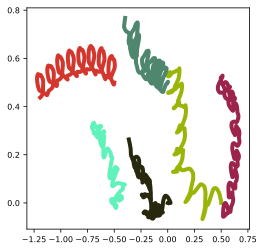

In [29]:
#@title Movement trajectories{vertical-output: true}

creature_colors = physics.bind(torsos).rgba[:, :3]
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(color=creature_colors)
_ = ax.plot(pos_x, pos_y, linewidth=4)

The plot above shows the corresponding movement trajectories of creature positions. Note how `physics.bind(torsos)` was used to access both `xpos` and `rgba` values. Once the `Physics` had been instantiated by `from_mjcf_model()`, the `bind()` method will expose both the associated `mjData` and `mjModel` fields of an `mjcf` element, providing unified access to all quantities in the simulation. 

# Composer tutorial

In this tutorial we will create a task requiring our "creature" above to press a colour-changing button on the floor with a prescribed force. We begin by implementing our creature as a `composer.Entity`:

In [30]:
#@title The `Creature` class


class Creature(composer.Entity):
  """A multi-legged creature derived from `composer.Entity`."""
  def _build(self, num_legs):
    self._model = make_creature(num_legs)

  def _build_observables(self):
    return CreatureObservables(self)

  @property
  def mjcf_model(self):
    return self._model

  @property
  def actuators(self):
    return tuple(self._model.find_all('actuator'))


# Add simple observable features for joint angles and velocities.
class CreatureObservables(composer.Observables):

  @composer.observable
  def joint_positions(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qpos', all_joints)

  @composer.observable
  def joint_velocities(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qvel', all_joints)

The `Creature` Entity includes generic Observables for joint angles and velocities. Because `find_all()` is called on the `Creature`'s MJCF model, it will only return the creature's leg joints, and not the "free" joint with which it will be attached to the world. Note that Composer Entities should override the `_build` and `_build_observables` methods rather than `__init__`. The implementation of `__init__` in the base class calls `_build` and `_build_observables`, in that order, to ensure that the entity's MJCF model is created before its observables. This was a design choice which allows the user to refer to an observable as an attribute (`entity.observables.foo`) while still making it clear which attributes are observables. The stateful `Button` class derives from `composer.Entity` and implements the `initialize_episode` and `after_substep` callbacks.

In [31]:
#@title The `Button` class

NUM_SUBSTEPS = 25  # The number of physics substeps per control timestep.


class Button(composer.Entity):
  """A button Entity which changes colour when pressed with certain force."""
  def _build(self, target_force_range=(5, 10)):
    self._min_force, self._max_force = target_force_range
    self._mjcf_model = mjcf.RootElement()
    self._geom = self._mjcf_model.worldbody.add(
        'geom', type='cylinder', size=[0.25, 0.02], rgba=[1, 0, 0, 1])
    self._site = self._mjcf_model.worldbody.add(
        'site', type='cylinder', size=self._geom.size*1.01, rgba=[1, 0, 0, 0])
    self._sensor = self._mjcf_model.sensor.add('touch', site=self._site)
    self._num_activated_steps = 0

  def _build_observables(self):
    return ButtonObservables(self)

  @property
  def mjcf_model(self):
    return self._mjcf_model
  # Update the activation (and colour) if the desired force is applied.
  def _update_activation(self, physics):
    current_force = physics.bind(self.touch_sensor).sensordata[0]
    self._is_activated = (current_force >= self._min_force and
                          current_force <= self._max_force)
    physics.bind(self._geom).rgba = (
        [0, 1, 0, 1] if self._is_activated else [1, 0, 0, 1])
    self._num_activated_steps += int(self._is_activated)

  def initialize_episode(self, physics, random_state):
    self._reward = 0.0
    self._num_activated_steps = 0
    self._update_activation(physics)

  def after_substep(self, physics, random_state):
    self._update_activation(physics)

  @property
  def touch_sensor(self):
    return self._sensor

  @property
  def num_activated_steps(self):
    return self._num_activated_steps


class ButtonObservables(composer.Observables):
  """A touch sensor which averages contact force over physics substeps."""
  @composer.observable
  def touch_force(self):
    return observable.MJCFFeature('sensordata', self._entity.touch_sensor,
                                  buffer_size=NUM_SUBSTEPS, aggregator='mean')

Note how the Button counts the number of sub-steps during which it is pressed with the desired force. It also exposes an `Observable` of the force being applied to the button, whose value is an average of the readings over the physics time-steps.

We import some `variation` modules and an arena factory:

In [32]:
#@title Random initialiser using `composer.variation`


class UniformCircle(variation.Variation):
  """A uniformly sampled horizontal point on a circle of radius `distance`."""
  def __init__(self, distance):
    self._distance = distance
    self._heading = distributions.Uniform(0, 2*np.pi)

  def __call__(self, initial_value=None, current_value=None, random_state=None):
    distance, heading = variation.evaluate(
        (self._distance, self._heading), random_state=random_state)
    return (distance*np.cos(heading), distance*np.sin(heading), 0)

In [33]:
#@title The `PressWithSpecificForce` task


class PressWithSpecificForce(composer.Task):

  def __init__(self, creature):
    self._creature = creature
    self._arena = floors.Floor()
    self._arena.add_free_entity(self._creature)
    self._arena.mjcf_model.worldbody.add('light', pos=(0, 0, 4))
    self._button = Button()
    self._arena.attach(self._button)

    # Configure initial poses
    self._creature_initial_pose = (0, 0, 0.15)
    button_distance = distributions.Uniform(0.5, .75)
    self._button_initial_pose = UniformCircle(button_distance)

    # Configure variators
    self._mjcf_variator = variation.MJCFVariator()
    self._physics_variator = variation.PhysicsVariator()

    # Configure and enable observables
    pos_corrptor = noises.Additive(distributions.Normal(scale=0.01))
    self._creature.observables.joint_positions.corruptor = pos_corrptor
    self._creature.observables.joint_positions.enabled = True
    vel_corruptor = noises.Multiplicative(distributions.LogNormal(sigma=0.01))
    self._creature.observables.joint_velocities.corruptor = vel_corruptor
    self._creature.observables.joint_velocities.enabled = True
    self._button.observables.touch_force.enabled = True

    def to_button(physics):
      button_pos, _ = self._button.get_pose(physics)
      return self._creature.global_vector_to_local_frame(physics, button_pos)

    self._task_observables = {}
    self._task_observables['button_position'] = observable.Generic(to_button)

    for obs in self._task_observables.values():
      obs.enabled = True

    self.control_timestep = NUM_SUBSTEPS * self.physics_timestep

  @property
  def root_entity(self):
    return self._arena

  @property
  def task_observables(self):
    return self._task_observables

  def initialize_episode_mjcf(self, random_state):
    self._mjcf_variator.apply_variations(random_state)

  def initialize_episode(self, physics, random_state):
    self._physics_variator.apply_variations(physics, random_state)
    creature_pose, button_pose = variation.evaluate(
        (self._creature_initial_pose, self._button_initial_pose),
        random_state=random_state)
    self._creature.set_pose(physics, position=creature_pose)
    self._button.set_pose(physics, position=button_pose)

  def get_reward(self, physics):
    return self._button.num_activated_steps / NUM_SUBSTEPS    

In [3]:
#@title Instantiating an environment{vertical-output: true}

creature = Creature(num_legs=4)
task = PressWithSpecificForce(creature)
env = composer.Environment(task, random_state=np.random.RandomState(42))

env.reset()
PIL.Image.fromarray(env.physics.render())

NameError: name 'Creature' is not defined

# The *Control Suite*

The **Control Suite** is a set of stable, well-tested tasks designed to serve as a benchmark for continuous control learning agents. Tasks are written using the basic MuJoCo wrapper interface. Standardised action, observation and reward structures make suite-wide benchmarking simple and learning curves easy to interpret. Control Suite domains are not meant to be modified, in order to facilitate benchmarking. For full details regarding benchmarking, please refer to our original [publication](https://arxiv.org/abs/1801.00690).

A video of solved benchmark tasks is [available here](https://www.youtube.com/watch?v=rAai4QzcYbs&feature=youtu.be).

The suite come with convenient module level tuples for iterating over tasks:

In [35]:
#@title Iterating over tasks{vertical-output: true}

max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
  print(f'{domain:<{max_len}}  {task}')

acrobot      swingup
acrobot      swingup_sparse
ball_in_cup  catch
cartpole     balance
cartpole     balance_sparse
cartpole     swingup
cartpole     swingup_sparse
cheetah      run
finger       spin
finger       turn_easy
finger       turn_hard
fish         upright
fish         swim
hopper       stand
hopper       hop
humanoid     stand
humanoid     walk
humanoid     run
manipulator  bring_ball
pendulum     swingup
point_mass   easy
reacher      easy
reacher      hard
swimmer      swimmer6
swimmer      swimmer15
walker       stand
walker       walk
walker       run


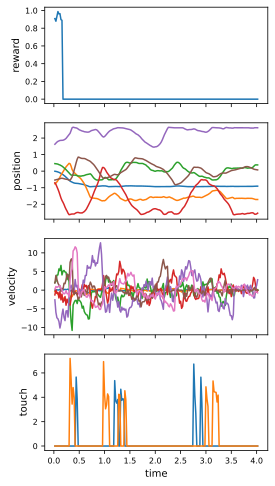

In [36]:
#@title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
random_state = np.random.RandomState(42)
env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 4  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:

  action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
  time_step = env.step(action)

  camera0 = env.physics.render(camera_id=0, height=200, width=200)
  camera1 = env.physics.render(camera_id=1, height=200, width=200)
  frames.append(np.hstack((camera0, camera1)))
  rewards.append(time_step.reward)
  observations.append(copy.deepcopy(time_step.observation))
  ticks.append(env.physics.data.time)

html_video = display_video(frames, framerate=1./env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)

html_video

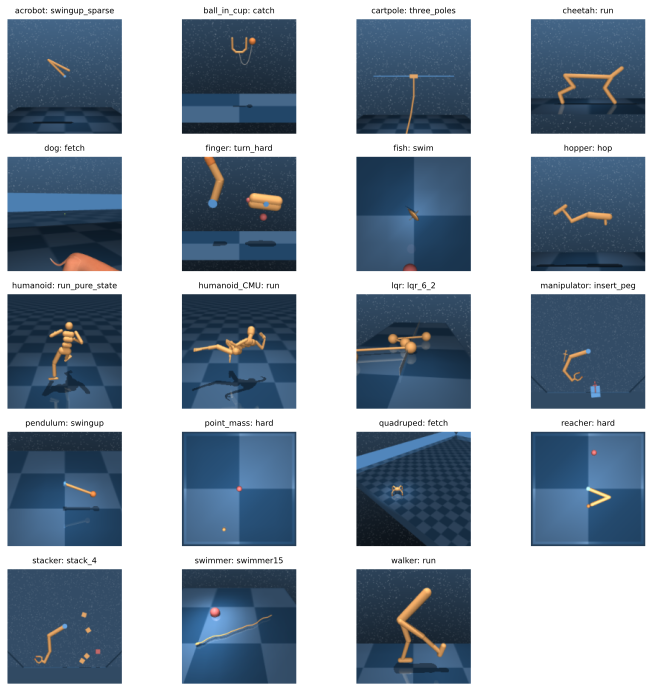

In [35]:
#@title Visualizing an initial state of one task per domain in the Control Suite
domains_tasks = {domain: task for domain, task in suite.ALL_TASKS}
random_state = np.random.RandomState(42)
num_domains = len(domains_tasks)
n_col = num_domains // int(np.sqrt(num_domains))
n_row = num_domains // n_col + int(0 < num_domains % n_col)
_, ax = plt.subplots(n_row, n_col, figsize=(12, 12))
for a in ax.flat:
  a.axis('off')
  a.grid(False)

print(f'Iterating over all {num_domains} domains in the Suite:')
for j, [domain, task] in enumerate(domains_tasks.items()):
  print(domain, task)

  env = suite.load(domain, task, task_kwargs={'random': random_state})
  timestep = env.reset()
  pixels = env.physics.render(height=200, width=200, camera_id=0)

  ax.flat[j].imshow(pixels)
  ax.flat[j].set_title(domain + ': ' + task)

clear_output()

# Locomotion

## Humanoid running along corridor with obstacles

As an illustrative example of using the Locomotion infrastructure to build an RL environment, consider placing a humanoid in a corridor with walls, and a task specifying that the humanoid will be rewarded for running along this corridor, navigating around the wall obstacles using vision. We instantiate the environment as a composition of the Walker, Arena, and Task as follows. First, we build a position-controlled CMU humanoid walker. 

In [36]:
#@title A position controlled `cmu_humanoid`

walker = cmu_humanoid.CMUHumanoidPositionControlledV2020(
    observable_options={'egocentric_camera': dict(enabled=True)})

Next, we construct a corridor-shaped arena that is obstructed by walls.

In [37]:
#@title A corridor arena with wall obstacles

arena = corridor_arenas.WallsCorridor(
    wall_gap=3.,
    wall_width=distributions.Uniform(2., 3.),
    wall_height=distributions.Uniform(2.5, 3.5),
    corridor_width=4.,
    corridor_length=30.,
)

The task constructor places the walker in the arena.

In [38]:
#@title A task to navigate the arena

task = corridor_tasks.RunThroughCorridor(
    walker=walker,
    arena=arena,
    walker_spawn_position=(0.5, 0, 0),
    target_velocity=3.0,
    physics_timestep=0.005,
    control_timestep=0.03,
)

Finally, a task that rewards the agent for running down the corridor at a specific velocity is instantiated as a `composer.Environment`.

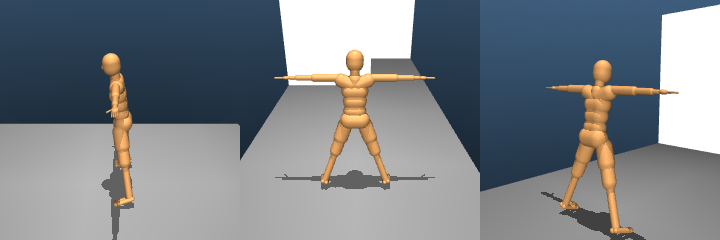

In [39]:
#@title The `RunThroughCorridor` environment

env = composer.Environment(
    task=task,
    time_limit=10,
    random_state=np.random.RandomState(42),
    strip_singleton_obs_buffer_dim=True,
)
env.reset()
pixels = []
for camera_id in range(3):
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
PIL.Image.fromarray(np.hstack(pixels))

## Multi-Agent Soccer

Building on Composer and Locomotion libraries, the Multi-agent soccer environments, introduced in [this paper](https://arxiv.org/abs/1902.07151), follow a consistent task structure of Walkers, Arena, and Task where instead of a single walker, we inject multiple walkers that can interact with each other physically in the same scene. The code snippet below shows how to instantiate a 2-vs-2 Multi-agent Soccer environment with the simple, 5 degree-of-freedom `BoxHead` walker type.

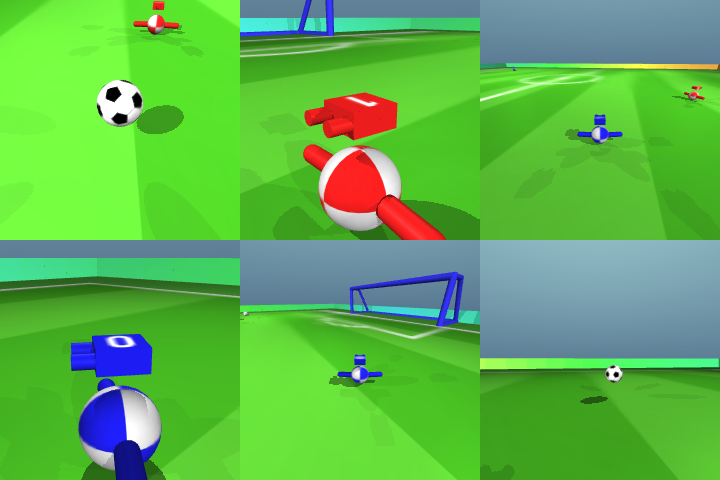

In [40]:
#@title 2-v-2 `Boxhead` soccer

random_state = np.random.RandomState(42)
env = soccer.load(
    team_size=2,
    time_limit=45.,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.BOXHEAD,
)
env.reset()
pixels = []
# Select a random subset of 6 cameras (soccer envs have lots of cameras)
cameras = random_state.choice(env.physics.model.ncam, 6, replace=False)
for camera_id in cameras:
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
image = np.vstack((np.hstack(pixels[:3]), np.hstack(pixels[3:])))
PIL.Image.fromarray(image)

 It can trivially be replaced by e.g. the `WalkerType.ANT` walker:

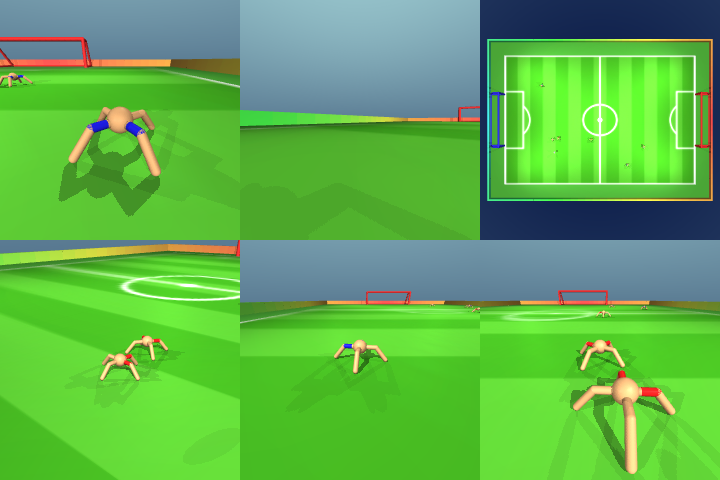

In [41]:
#@title 3-v-3 `Ant` soccer

random_state = np.random.RandomState(42)
env = soccer.load(
    team_size=3,
    time_limit=45.,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.ANT,
)
env.reset()

pixels = []
cameras = random_state.choice(env.physics.model.ncam, 6, replace=False)
for camera_id in cameras:
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
image = np.vstack((np.hstack(pixels[:3]), np.hstack(pixels[3:])))
PIL.Image.fromarray(image)

# Manipulation

The `manipulation` module provides a robotic arm, a set of simple objects, and tools for building reward functions for manipulation tasks.

In [42]:
#@title Listing all `manipulation` tasks{vertical-output: true}

# `ALL` is a tuple containing the names of all of the environments in the suite.
print('\n'.join(manipulation.ALL))

stack_2_bricks_features
stack_2_bricks_vision
stack_2_bricks_moveable_base_features
stack_2_bricks_moveable_base_vision
stack_3_bricks_features
stack_3_bricks_vision
stack_3_bricks_random_order_features
stack_2_of_3_bricks_random_order_features
stack_2_of_3_bricks_random_order_vision
reassemble_3_bricks_fixed_order_features
reassemble_3_bricks_fixed_order_vision
reassemble_5_bricks_random_order_features
reassemble_5_bricks_random_order_vision
lift_brick_features
lift_brick_vision
lift_large_box_features
lift_large_box_vision
place_brick_features
place_brick_vision
place_cradle_features
place_cradle_vision
reach_duplo_features
reach_duplo_vision
reach_site_features
reach_site_vision


In [43]:
#@title Listing `manipulation` tasks that use vision{vertical-output: true}
print('\n'.join(manipulation.get_environments_by_tag('vision')))

stack_2_bricks_vision
stack_2_bricks_moveable_base_vision
stack_3_bricks_vision
stack_2_of_3_bricks_random_order_vision
reassemble_3_bricks_fixed_order_vision
reassemble_5_bricks_random_order_vision
lift_brick_vision
lift_large_box_vision
place_brick_vision
place_cradle_vision
reach_duplo_vision
reach_site_vision


In [ ]:
#@title Loading and simulating a `manipulation` task{vertical-output: true}

env = manipulation.load('stack_2_of_3_bricks_random_order_vision', seed=42)
action_spec = env.action_spec()

def sample_random_action():
  return env.random_state.uniform(
      low=action_spec.minimum,
      high=action_spec.maximum,
  ).astype(action_spec.dtype, copy=False)

# Step the environment through a full episode using random actions and record
# the camera observations.
frames = []
timestep = env.reset()
frames.append(timestep.observation['front_close'])
while not timestep.last():
  timestep = env.step(sample_random_action())
  frames.append(timestep.observation['front_close'])
all_frames = np.concatenate(frames, axis=0)
display_video(all_frames, 30)

NameError: name 'manipulation' is not defined